In [1]:
pip install torch torchvision opencv-python matplotlib

Note: you may need to restart the kernel to use updated packages.


In [4]:
import torchvision
from torchvision import transforms
from PIL import Image
import torch

model = torchvision.models.detection.ssd300_vgg16(pretrained=True)
model.eval()

transform = transforms.Compose([
    transforms.Resize((300, 300)),
    transforms.ToTensor(),
])

img = Image.open("perros.jpg").convert("RGB")  # Convertir a RGB para remover canal alpha si existe
x = transform(img).unsqueeze(0)

with torch.no_grad():
    preds = model(x)

print(preds)

/home/lord/Desktop/-Proyecto-Integrador-II-Codelabs/.venv/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/lord/Desktop/-Proyecto-Integrador-II-Codelabs/.venv/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=SSD300_VGG16_Weights.COCO_V1`. You can also use `weights=SSD300_VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


[{'boxes': tensor([[ 43.3104,  19.6859, 259.5156, 281.6089],
        [212.6658,  70.5799, 253.7495, 107.6644],
        [191.4698,  54.5203, 249.4993,  92.5683],
        [186.2161,  33.4305, 249.8220,  75.2021],
        [115.9605,  58.4813, 147.5808,  90.6016],
        [141.6178,  58.4040, 171.1899,  91.7226],
        [ 39.4209,   1.1763,  69.2152,  74.5933],
        [134.7187,  50.7072, 163.7488,  86.4101],
        [122.6716,  65.8674, 141.4856,  85.2081],
        [199.8597,  65.3141, 237.1640, 112.6325],
        [ 20.5425,   1.6945,  54.6700,  71.7347],
        [ 98.0048,  58.6238, 133.4924,  92.2599],
        [122.2836,  56.4197, 140.1325,  78.9024],
        [109.2917,  51.7969, 138.9665,  84.5534],
        [ 13.8472,   0.0000,  79.4911,  88.6105],
        [132.2548,  66.0327, 148.6939,  85.6841],
        [ 58.8627,   0.0000,  85.7086,  41.3823],
        [175.5992,  24.1428, 253.8296,  58.8475],
        [115.6981,  66.6369, 134.0238,  84.8234],
        [140.7846,  66.1279, 157.6501, 

SSD: 0.8429319858551025 seg


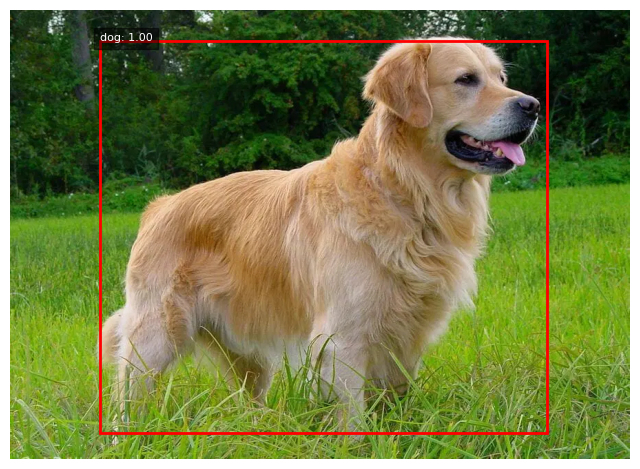

In [5]:
from torchvision.models.detection import ssd300_vgg16, SSD300_VGG16_Weights
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import torch
import time

# Cargar SSD300-VGG16 con pesos preentrenados por defecto (COCO) y ponerlo en modo evaluación para inferencia
weights = SSD300_VGG16_Weights.DEFAULT
model = ssd300_vgg16(weights=weights).eval()

# Transforms correctos (no redimensionan fijo a 300x300, se encargan de escalar de forma consistente). Prepara la imagen igual que durante el entrenamiento (resize, normalización, etc.) para que el modelo la entienda bien
preprocess = weights.transforms()

# Imagen
img = Image.open("perros.jpg").convert("RGB")

# Convierte la imagen en un tensor preprocesado y le agrega la dimensión de batch (1 imagen)
x = preprocess(img).unsqueeze(0)

# Ejecuta el modelo en modo inferencia (sin gradientes) y obtiene las predicciones de la única imagen del batch
with torch.no_grad():
    t0 = time.time()  
    out = model(x)[0]  
    t1 = time.time()  
  
print("SSD:", t1-t0, "seg")

# Boxes ya están en escala original 🎉
boxes, labels, scores = out["boxes"], out["labels"], out["scores"]

# Lista de nombres de clases (COCO) que corresponde a los índices de 'labels' en las predicciones
categories = weights.meta["categories"]

# Visualizar
fig, ax = plt.subplots(1, figsize=(8, 6))
ax.imshow(img)
for box, lab, sc in zip(boxes, labels, scores):
    if sc > 0.5:  # filtrar confianza
        x1, y1, x2, y2 = box.tolist()
        rect = patches.Rectangle((x1, y1), x2-x1, y2-y1, linewidth=2,
                                 edgecolor="red", facecolor="none")
        ax.add_patch(rect)
        ax.text(x1, y1, f"{categories[int(lab)]}: {sc:.2f}",
                color="white", fontsize=8,
                bbox=dict(facecolor="black", alpha=0.5))
plt.axis("off")
plt.show()

In [7]:
from ultralytics import YOLO

model_yolo = YOLO("yolov8n.pt")
results = model_yolo("perros.jpg")

# results es una lista de objetos Results. Mostrar el primero
if isinstance(results, list):
    results[0].show()
else:
    results.show()


image 1/1 /home/lord/Desktop/-Proyecto-Integrador-II-Codelabs/Codelab6 SSD/perros.jpg: 480x640 1 dog, 189.4ms
Speed: 3.6ms preprocess, 189.4ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)
image 1/1 /home/lord/Desktop/-Proyecto-Integrador-II-Codelabs/Codelab6 SSD/perros.jpg: 480x640 1 dog, 189.4ms
Speed: 3.6ms preprocess, 189.4ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)


/usr/bin/eog: symbol lookup error: /snap/core20/current/lib/x86_64-linux-gnu/libpthread.so.0: undefined symbol: __libc_pthread_init, version GLIBC_PRIVATE


In [8]:
def iou(boxA, boxB):
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2])
    yB = min(boxA[3], boxB[3])

    interArea = max(0, xB-xA) * max(0, yB-yA)
    boxAArea = (boxA[2]-boxA[0]) * (boxA[3]-boxA[1])
    boxBArea = (boxB[2]-boxB[0]) * (boxB[3]-boxB[1])

    return interArea / float(boxAArea + boxBArea - interArea)